
## LLM-based IoC extraction

Tim Angevare - t.p.angevare@student.utwente.nl

This notebook evaluates LLM based entity extraction and uses fine tuning methods to improve f1-score:


**Target IoC Types:**
- Email addresses
- IP addresses (v4/v6)
- Financial addresses (IBAN, BTC, etc)
- Person names
- Locations
- Domains
- Usernames

Methodology based on cake recipe
https://github.com/jjsantanna/cake_recipe_for_students/blob/master/cake_of_llm.md

## Section 1: Setup & Environment

In [2]:
import os
# Set GPU 3 as the only visible GPU (must be before importing torch/transformers)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import ollama
from datetime import datetime
import json
from pathlib import Path
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from collections import defaultdict
import subprocess

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Ollama configuration and Initial model selection

In [4]:
# Ollama configuration
options = {
    'temperature': 0,
    'top_p': 1,
    'top_k' : 0,
    'seed': 1234,
    'num_ctx': 8192
}

models = [ 
    'llama3.2:3b', 'phi3:3.8b', 'gemma:2b',
    'deepseek-r1:14b', 'deepseek-r1:7b', 'gemma3:12b', 'gemma3:4b', 
    'qwen3:14b', 'qwen3:8b', 'llama3:8b',
    'mistral:7b', 'phi4:14b', 
    'qwen2.5:7b', 'qwen2.5:14b', 'mixtral:8x7b', 'granite3.3:8b', 
    'nuextract', "hf.co/CyberNative-AI/Colibri_8b_v0.1_q5_gguf:Q5_K_M", 
    "hf.co/RichardErkhov/ZySec-AI_-_SecurityLLM-gguf:Q4_K_M", 
    "hf.co/segolilylabs/Lily-Cybersecurity-7B-v0.2-GGUF:Q4_K_M"
]



print(f"Total models to evaluate: {len(models)}")

Total models to evaluate: 20


In [5]:
for model in models:
    proc = subprocess.run(["ollama", "pull", model], capture_output=True, text=True)
    if proc.returncode == 0:
        print(f"Pulled {model}")
        print(proc.stdout)
    else:
        print(f"Failed to pull {model}")
        print(proc.stderr)

Failed to pull llama3.2:3b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull phi3:3.8b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull gemma:2b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull deepseek-r1:14b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull deepseek-r1:7b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull gemma3:12b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull gemma3:4b
Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it

Failed to pull qwen3:14b
Error: ollama server not responding - could n

## Section 2: Dataset Preparation
### 2.1 Load The Cipher Trail Document

In [6]:
documents_path = Path('Cipher mails')

print(f"documents: {len(list(documents_path.glob('*.json')))}")

documents: 13


In [7]:
def parse_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['entities'], data['text']

dataset = {
    "gt_entities" : [],
    "regex_entities" : [],
    "regex_metrics" : [],
    "regex_time" : [],
    "nlp_entities" : [],
    "cyner_entities" : [],
    "text" : [],
    "filenames" : []
}

for file in documents_path.glob('*.json'):
    entities, text = parse_json_file(file)
    dataset['gt_entities'].append(entities)
    dataset['text'].append(text)
    dataset['filenames'].append(file.name)

print(f"Loaded {len(dataset['filenames'])} documents.")
types = []

for files in dataset['gt_entities']:
    for entity in files:
        if entity['type'] not in types:
            types.append(entity['type'])

print(f"Entity types in ground truth: {types}")

Loaded 13 documents.
Entity types in ground truth: ['EMAIL', 'BTC', 'PERSON', 'LOCATION', 'IP', 'TOX', 'URL', 'PHONE']


## Section 3: Evaluation Metrics

These functions calculate precision, recall, and F1-score for entity extraction.

In [8]:
def compute_overlap(span1, span2):
    """
    Compute Intersection over Union (IoU) for two spans.
    span: (start, end) tuple
    """
    start1, end1 = span1
    start2, end2 = span2
    
    # Compute intersection
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    
    if intersection_start >= intersection_end:
        return 0.0
    
    intersection = intersection_end - intersection_start
    
    # Compute union
    union = (end1 - start1) + (end2 - start2) - intersection
    
    return intersection / union if union > 0 else 0.0


def entity_matches(pred_entity, gt_entity, match_type='partial'):
    """
    Check if predicted entity matches ground truth entity.
    
    Args:
        pred_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        gt_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' (exact span match) or 'partial' (IoU > 0.5)
    
    Returns:
        float: 1.0 for exact match, 0.5 for partial match, 0.0 for no match
    """
    # Type must match
    if pred_entity['type'].lower() != gt_entity['type'].lower():
        return 0.0
    
    # If positions are not available, use text matching
    if pred_entity.get('start_pos', -1) == -1 or gt_entity.get('start_pos', -1) == -1:
        if pred_entity['text'].lower() == gt_entity['text'].lower():
            return 1.0
        return 0.0
    
    pred_span = (pred_entity['start_pos'], pred_entity['end_pos'])
    gt_span = (gt_entity['start_pos'], gt_entity['end_pos'])
    
    if match_type == 'exact':
        # Exact span match
        if pred_span == gt_span:
            return 1.0
        return 0.0
    
    elif match_type == 'partial':
        # Partial match using IoU
        iou = compute_overlap(pred_span, gt_span)
        if iou >= 0.5:
            return 0.5  # Partial credit
        return 0.0
    
    return 0.0


def calculate_ner_metrics(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics: Precision, Recall, F1-score.
    
    Args:
        predicted_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        ground_truth_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' or 'partial'
    
    Returns:
        dict with 'precision', 'recall', 'f1', 'tp', 'fp', 'fn'
    """
    TP = 0.0
    FP = 0.0
    FN = 0.0
    FP_entities = []
    
    # Track which GT entities have been matched
    matched_gt = set()
    
    # Check each predicted entity
    for pred_ent in predicted_entities:
        best_match_score = 0.0
        best_match_idx = -1
        
        for idx, gt_ent in enumerate(ground_truth_entities):
            if idx in matched_gt:
                continue
            
            score = entity_matches(pred_ent, gt_ent, match_type)
            if score > best_match_score:
                best_match_score = score
                best_match_idx = idx
        
        if best_match_score > 0:
            TP += best_match_score
            matched_gt.add(best_match_idx)
        else:
            FP += 1
            FP_entities.append(pred_ent)
    
    # Count unmatched ground truth entities as false negatives
    FN = len(ground_truth_entities) - len(matched_gt)
    FN_entities= [gt for index, gt in enumerate(ground_truth_entities) if index not in matched_gt]
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': TP,
        'fp': FP,
        'fn': FN,
        'fp entities' : FP_entities,
        'fn entities' : FN_entities
    }


def calculate_ner_metrics_by_type(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics for each entity type separately.
    
    Returns:
        dict: {entity_type: {precision, recall, f1}}
    """
    # Get all unique entity types
    all_types = set()
    for ent in predicted_entities + ground_truth_entities:
        all_types.add(ent['type'].lower())
    
    results = {}
    for ent_type in all_types:
        pred_type = [e for e in predicted_entities if e['type'].lower() == ent_type]
        gt_type = [e for e in ground_truth_entities if e['type'].lower() == ent_type]
        
        metrics = calculate_ner_metrics(pred_type, gt_type, match_type)
        results[ent_type] = metrics
    
    return results

In [9]:
def calc_avg_ner_metrics(pred_entities):
    precision = []
    recall = []
    f1 = []
    TP = 0
    FP = 0
    FN = 0
    FP_entities = []
    FN_entities = []

    for idx in range(len(dataset['filenames'])):
        metrics = calculate_ner_metrics(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        precision.append(metrics['precision'])
        recall.append(metrics['recall'])
        f1.append(metrics['f1'])
        TP += metrics['tp']
        FP += metrics['fp']
        FN += metrics['fn'],
        FP_entities += metrics['fp entities']
        FN_entities += metrics['fn entities']
    avg_metrics = {
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'f1': np.mean(f1),
        'tp': TP,
        'fp': FP,
        'fn': FN,
        'fp entities' : FP_entities,
        'fn entities' : FN_entities
    }
    return avg_metrics

#dataset['regex_metrics'] = calc_avg_ner_metrics(dataset['regex_entities'])


In [10]:
# Calculate metrics by type
def calc_avg_ner_metrics_by_type(pred_entities):
    type_stats = defaultdict(lambda: defaultdict(list))

    for idx in range(len(dataset['filenames'])):
        regex_metrics_by_type = calculate_ner_metrics_by_type(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        for entity_type, metrics in regex_metrics_by_type.items():
            for metric_name, value in metrics.items():
                type_stats[entity_type][metric_name].append(value)

    averages = {}
    for entity_type, metrics_lists in type_stats.items():
        averages[entity_type] = {}
        for metric_name, values in metrics_lists.items():
            averages[entity_type][metric_name] = sum(values) / len(values)
    return averages


## Section 6: Method 3 - LLM Extraction
## 6.1 Define 3 different Prompts to evaluate performance

In [11]:
ENTITY_TYPES = """
- EMAIL: email addresses format (user@domain.tld)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- BTC: ONLY Bitcoin wallet addresses (26-35 alphanumeric, starting with 1, 3, or bc1) EXCLUDE the word bitcoin or values (for example 2.0 BTC)
- IBAN: iban bank account number
- PERSON: Human names (John Smith, John, Catalina) EXCLUDE initials (for example A.H.) 
- LOCATION: cities, countries, geographic locations
- PHONE: phone numbers in any format
- URL: URLs and web addresses EXCLUDE filenames
- TOX: Tox messenger IDs
"""

# Prompt 1: Task + Format
prompt_1_task_format = f"""Your task is to extract any entity from the input text. For each entity found you MUST indicate the type in UPPERCASE. ONLY extract entities if literal entity is present in input text.
The expected entity types are the following:

{ENTITY_TYPES}
 
**Output**:
The output MUST be in a JSON object with key 'entities' and the value a list of dictionaries including every entity found. For each entity you MUST indicate the type in UPPERCASE.
{{"entities": [{{"entity" : "text", "type" : "TYPE"}}]}}

Return empty array if no entities found in the input text.
PAY ATTENTION to sentences that begin with entity type PERSON, for example Anna.
PAY ATTENTION to when the sentences begin with possesive forms of entity type PERSON, for example Catalina's
PAY ATTENTION to when the sentences contain a FULL NAME, the FULL NAME MUST be extracted as ONE entity.
DO NOT include any entities from the example or the system prompt in your answer.
"""

# Prompt 2: Role + Task + Format
prompt_2_role_task_format = """You are a cyber intelligence analyst with 20 years of experience in the the field.

""" + prompt_1_task_format

# Prompt 3: Role + Task + Format + Few-shot
few_shot_examples = '''
**OUTPUT EXAMPLE**:
{
  "entities": [
    {"entity": "target123@darkmail.org", "type": "EMAIL"},
    {"entity": "10.45.67.89", "type": "IP"},
    {"entity": "Thompson", "type": "PERSON"},
    {"entity": "Helsinki", "type": "LOCATION"},
    {"entity": "Tim", "type": "PERSON"}
  ]
}
'''

prompt_3_role_task_format_example = prompt_2_role_task_format + few_shot_examples

prompt_4_role_task_format_example_verification = prompt_3_role_task_format_example + """
**Verification**:
1. verify that your answer in valid JSON format.
2. verify that all extracted entities are present in the input text.
3. verify that no entities from the example or system prompt are included in your answer.
4. verify that extracted entities match the expected formats for their types.
5. provide your final revised answer based on the verifications above.
"""

psuedo_code_role_task_format_example = f'''
EXECUTE the following function logic strictly.

CONST ENTITY_TYPES = {{
    {ENTITY_TYPES}
}}

DEF analyze_document(input_text):
        CONST SCOPE = [EMAIL, IP, BTC, IBAN, PERSON, LOCATION, PHONE, URL, TOX]

        extracted_artifacts = []
        
        # EXTRACTION LOOP
        ITERATE through input_text searching for SCOPE:
            MATCH criteria:
                IF type is PERSON:
                    full or partial (First, Last, Initials)
                ELSE:
                    MATCH standard pattern
            
            # DUPLICATE HANDLING
            IF entity exists in extracted_artifacts:
                ADD it again (We need frequency/location data)
                
            APPEND {{
                "entity": match.text,
                "type": match.type.UPPER(),
            }} to extracted_artifacts

        # RETURN
        response_object = {{
            "entities": extracted_artifacts,
        }}
        
        RETURN JSON(response_object) ''' + few_shot_examples

prompt_strategies = {
    'role and task' : prompt_1_task_format,
    'role task and format' : prompt_2_role_task_format,
    'role task format and example' : prompt_3_role_task_format_example,
    'role task format example and verification' : prompt_4_role_task_format_example_verification,
    'psuedo code role task format ' : psuedo_code_role_task_format_example
}

print(f"✓ Defined {len(prompt_strategies)} prompt strategies")
print(f"\n=== Prompt 1 Preview ===")
print(prompt_1_task_format[:200] + "...")

✓ Defined 5 prompt strategies

=== Prompt 1 Preview ===
Your task is to extract any entity from the input text. For each entity found you MUST indicate the type in UPPERCASE. ONLY extract entities if literal entity is present in input text.
The expected en...


## 6.2 LLM Output Parsing

In [12]:
def parse_llm_output(llm_response, source_text=""):
    """
    Parse LLM output to extract entities.
    Handles various output formats and errors.
    
    Args:
        llm_response: string response from LLM
        source_text: original source text (for finding entity positions)
    
    Returns:
        dict with 'entities' list
    """
    output = {'entities': []}
    
    try:
        # Try to extract JSON from response
        response_clean = llm_response.strip()
        
        # Remove markdown code blocks if present
        if '```json' in response_clean:
            start = response_clean.find('```json') + 7
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        elif '```' in response_clean:
            start = response_clean.find('```') + 3
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        
        # Parse JSON
        parsed = json.loads(response_clean)
        
        # Extract entities
        if 'entities' in parsed:
            for ent in parsed['entities']:
                entity = {
                    'text': ent.get('entity', ent.get('text', '')),
                    'type': ent.get('type', '').lower(),
                    'start_pos': ent.get('start_pos', -1),
                    'end_pos': ent.get('end_pos', -1)
                }
                
                output['entities'].append(entity)
        if 'confidence' in parsed:
            output['confidence'] = parsed['confidence']
        if 'reason' in parsed:
            output['reason'] = parsed['reason']
    
    except json.JSONDecodeError as e:
        print(f"JSON parsing failed: {e}")
    
    except Exception as e:
        print(f"Error parsing LLM output: {e}")
    
    return output

### Helper function in order to determine character positions of extracted entities after the fact

In [13]:
def find_entity_position(entity_text: str, source_text: str, start_search: int = 0):
    """
    Find the character position of an entity in source text.
    Uses case-insensitive exact matching first, then falls back to fuzzy matching.
    
    Args:
        entity_text: The entity text to find
        source_text: The source document text
        start_search: Character position to start searching from
    
    Returns:
        Tuple of (start_pos, end_pos) or (-1, -1) if not found
    """
    if not entity_text or not source_text:
        return (-1, -1)
    
    # Clean up entity text (remove extra whitespace)
    entity_text = ' '.join(entity_text.split())
    
    # Try case-insensitive exact match first
    lower_source = source_text.lower()
    lower_entity = entity_text.lower()
    
    start_pos = lower_source.find(lower_entity, start_search)
    if start_pos != -1:
        end_pos = start_pos + len(entity_text)
        return (start_pos, end_pos)
    
    # Fallback: Try fuzzy matching for minor variations
    # This handles cases where there might be extra spaces or minor differences
    try:
        # Search in windows of text similar to entity length
        window_size = len(entity_text) + 10
        best_ratio = 0.0
        best_pos = (-1, -1)
        
        for i in range(len(source_text) - len(entity_text) + 1):
            window = source_text[i:i + window_size]
            ratio = SequenceMatcher(None, lower_entity, window.lower()).ratio()
            
            if ratio > best_ratio and ratio > 0.8:  # 80% similarity threshold
                best_ratio = ratio
                best_pos = (i, i + len(entity_text))
        
        if best_pos != (-1, -1):
            return best_pos
    except Exception as e:
        print(f"Error in fuzzy matching: {e}")
    
    # Not found
    return (-1, -1)

## 6.3 LLM Testing Pipeline

Test a single LLM on text with a specific prompt strategy.

In [14]:
def chat(model_name, prompt_strategy, text, options, max_retries=3):
    retry_counter = 0
    error = ''
    while retry_counter < max_retries:
        try:
            start_time = datetime.now()
            
            # Call LLM
            response = ollama.chat(
                model=model_name,
                messages=[
                    {"role": "system", "content": prompt_strategy},
                    {"role": "user", "content": text}
                ],
                format='json',
                options=options
            )
            
            elapsed_time = (datetime.now() - start_time).total_seconds()
            llm_output = response['message']['content']
            parsed = parse_llm_output(llm_output, text)
            return  parsed, elapsed_time
            
        except Exception as e:
            error = str(e)
            print(f"Error during LLM call or processing: {e}")
            retry_counter += 1
            print(f"Retrying... ({retry_counter}/{max_retries})")
    
    return {}, 0

Also takes an argument with a delimiter (paragraph, sentence) and parses the output in chunks

In [15]:
def test_llm_on_text(model_name, prompt_strategy, text, ground_truth_entities, options, delimiter='', max_retries=3):
    
    if delimiter == '':
        parsed, elapsed_time = chat(model_name, prompt_strategy, text, options, max_retries)
    else:
        text_arr = text.split(delimiter)
        elapsed_time = 0
        parsed = {'entities' : [], 'confidence' : '', 'reason' : ''}
        for text_chunk in text_arr:
            chunk_parsed, chunk_elapsed_time = chat(model_name, prompt_strategy, text_chunk , options, max_retries)
            elapsed_time += chunk_elapsed_time
            parsed['entities'] += chunk_parsed['entities']
            if 'confidence' in chunk_parsed:
                parsed['confidence'] += chunk_parsed['confidence']
            if 'reason' in chunk_parsed:
                parsed['reason'] += chunk_parsed['reason']
    
    if len(parsed) == 0:
        return {
            'success': False,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'elapsed_time': 0
        }
    for ent in parsed['entities']:
        start_pos, end_pos = find_entity_position(ent['text'], text)
        ent['start_pos'] = start_pos
        ent['end_pos'] = end_pos
 
    ner_metrics = calculate_ner_metrics(
        parsed['entities'],
        ground_truth_entities,
        match_type='partial'
    )
            
    return {
        'success': True,
        'precision': ner_metrics['precision'],
        'recall': ner_metrics['recall'],
        'f1': ner_metrics['f1'],
        'tp': ner_metrics['tp'],
        'fp': ner_metrics['fp'],
        'fn': ner_metrics['fn'],
        'predicted_entities': parsed['entities'],
        'gt_entities': ground_truth_entities,
        'fp_entities' : ner_metrics['fp entities'],
        'fn_entities' : ner_metrics['fn entities'],
        'elapsed_time': elapsed_time,
        'output': parsed
    }

## 6.4 Run LLM Experiments

This will test all models with all prompt strategies.

In [46]:
def run_llm_experiments_chunks(models, prompt, texts, ground_truth_entities, options, chunks, filenames, output_file='llm_chunk_results.csv'):
    total_experiments = len(models) * len(chunks) * len(texts)
    experiment_count = 0
    
    print(f"Starting LLM context chunking experiments: {total_experiments} total tests")
    print(f"Models: {len(models)}, chunks: {len(chunks)}")
    print("="*80)
    for model in models:
        print(f"\nTesting model: {model}")
        model_results = []
        
        for delimiter in chunks:
            for idx in range(len(texts)):
                filename = filenames[idx]
                experiment_count += 1
                begin_time = datetime.now().strftime("%H:%M:%S")
                print(f"  {begin_time} [{experiment_count}/{total_experiments}] delimeter: {delimiter} File: {filename}" , end=" ")
                result = test_llm_on_text(model, prompt, texts[idx], ground_truth_entities[idx], options, delimiter)
            
                # Add metadata
                result.update({
                    'model': model,
                    'prompt_strategy': prompt,
                    'delimiter' : delimiter,
                    'file' : filename
                })
                
                model_results.append(result)
                end_time = datetime.now().strftime("%H:%M:%S")
                
                if result['success']:
                    print(f"{end_time} F1: {result['f1']:.3f}, P: {result['precision']:.3f}, R: {result['recall']:.3f}, Time: {result['elapsed_time']:.2f}s")
                else:
                    print(f"{end_time} Failed: {result.get('error', 'Unknown error')[:50]}")
        
        # Save incrementally after each model
        results_df = pd.DataFrame(model_results)
        
        if os.path.isfile(output_file):
            results_df.to_csv(output_file, mode='a', index=False, header=False)
        else:
            results_df.to_csv(output_file, index=False)
            
        print(f"\n✓ Results saved to {output_file}")
    
    # Load and return final results
    total_results_df = pd.read_csv(output_file)
    return total_results_df

In [47]:
def run_llm_experiments(models, prompt_strategies, texts, ground_truth_entities, options, output_file='llm_results.csv'):
    
    total_experiments = len(models) * len(prompt_strategies) * len(texts)
    experiment_count = 0
    
    print(f"Starting LLM prompt experiments: {total_experiments} total tests")
    print(f"Models: {len(models)}, Prompts: {len(prompt_strategies)}")
    print("="*80)
    
    for model in models:
        print(f"\nTesting model: {model}")
        model_results = []
        
        for prompt_name, prompt_text in prompt_strategies.items():
            for idx in range(len(texts)):
                filename = dataset['filenames'][idx]
                experiment_count += 1
                begin_time = datetime.now().strftime("%H:%M:%S")
                print(f"  {begin_time} [{experiment_count}/{total_experiments}] Prompt: {prompt_name} File: {filename}" , end=" ")
            
                result = test_llm_on_text(model, prompt_text, texts[idx], ground_truth_entities[idx], options)
            
                # Add metadata
                result.update({
                    'model': model,
                    'prompt_strategy': prompt_name,
                    'file' : filename
                })
                
                model_results.append(result)
                end_time = datetime.now().strftime("%H:%M:%S")
                
                if result['success']:
                    print(f"{end_time} F1: {result['f1']:.3f}, P: {result['precision']:.3f}, R: {result['recall']:.3f}, Time: {result['elapsed_time']:.2f}s")
                else:
                    print(f"{end_time} Failed: {result.get('error', 'Unknown error')[:50]}")
        
        # Save incrementally after each model
        results_df = pd.DataFrame(model_results)
        
        if os.path.isfile(output_file):
            results_df.to_csv(output_file, mode='a', index=False, header=False)
        else:
            results_df.to_csv(output_file, index=False)
            
        print(f"\n✓ Results saved to {output_file}")
    
    # Load and return final results
    total_results_df = pd.read_csv(output_file)
    print(f"\n✓ Results saved to {output_file}")
    return total_results_df

print("Experiment runner loaded")
print(f"\nTotal experiments: {len(models)} models × {len(prompt_strategies)} prompts x user inputs {len(dataset['text'])} = {len(models) * len(prompt_strategies) * len(dataset['text'])}")

Experiment runner loaded

Total experiments: 20 models × 5 prompts x user inputs 13 = 1300


## Experiment to test prompt styles

In [48]:
llm_results = run_llm_experiments(
    models,
    prompt_strategies,
    dataset['text'][:5],
    dataset['gt_entities'][:5],
    options,
    output_file='cipher_trail_llm_results.csv'
)

Starting LLM prompt experiments: 500 total tests
Models: 20, Prompts: 5

Testing model: llama3.2:3b
  12:53:57 [1/500] Prompt: role and task File: 5.json 12:54:21 F1: 0.667, P: 1.000, R: 0.500, Time: 24.75s
  12:54:21 [2/500] Prompt: role and task File: 4.json 12:54:23 F1: 0.444, P: 0.667, R: 0.333, Time: 1.97s
  12:54:23 [3/500] Prompt: role and task File: 3.json 12:54:26 F1: 0.667, P: 1.000, R: 0.500, Time: 2.17s
  12:54:26 [4/500] Prompt: role and task File: 6.json 12:54:28 F1: 0.400, P: 0.600, R: 0.300, Time: 2.94s
  12:54:28 [5/500] Prompt: role and task File: 7.json 12:54:31 F1: 0.889, P: 1.000, R: 0.800, Time: 2.17s
  12:54:31 [6/500] Prompt: role task and format File: 5.json 12:54:35 F1: 0.600, P: 0.750, R: 0.500, Time: 4.07s
  12:54:35 [7/500] Prompt: role task and format File: 4.json 12:54:37 F1: 0.444, P: 0.667, R: 0.333, Time: 2.07s
  12:54:37 [8/500] Prompt: role task and format File: 3.json 12:54:39 F1: 0.667, P: 1.000, R: 0.500, Time: 2.30s
  12:54:39 [9/500] Prompt: rol

Let's see if we chunck the context by paragraph or sentence the performance improves

In [57]:
final_models = ['gemma3:12b', 'qwen2.5:14b', 'deepseek-r1:14b']

In [69]:
llm_chunking_results = run_llm_experiments_chunks(
    final_models,
    prompt_3_role_task_format_example,
    dataset['text'],
    dataset['gt_entities'],
    options,
    ['. '],
    dataset['filenames'],
    output_file='final_llm_results.csv'
)

Starting LLM context chunking experiments: 39 total tests
Models: 3, chunks: 1

Testing model: gemma3:12b
  14:27:47 [1/39] delimeter: .  File: 5.json 14:28:19 F1: 0.667, P: 1.000, R: 0.500, Time: 32.54s
  14:28:19 [2/39] delimeter: .  File: 4.json 14:28:32 F1: 0.909, P: 1.000, R: 0.833, Time: 12.82s
  14:28:32 [3/39] delimeter: .  File: 3.json 14:28:44 F1: 0.667, P: 1.000, R: 0.500, Time: 11.71s
  14:28:44 [4/39] delimeter: .  File: 6.json 14:29:09 F1: 0.900, P: 0.900, R: 0.900, Time: 25.23s
  14:29:09 [5/39] delimeter: .  File: 7.json 14:29:27 F1: 1.000, P: 1.000, R: 1.000, Time: 18.12s
  14:29:27 [6/39] delimeter: .  File: 8.json 14:29:45 F1: 0.769, P: 1.000, R: 0.625, Time: 17.46s
  14:29:45 [7/39] delimeter: .  File: 2.json 14:29:54 F1: 1.000, P: 1.000, R: 1.000, Time: 8.71s
  14:29:54 [8/39] delimeter: .  File: 1.json 14:30:18 F1: 0.857, P: 1.000, R: 0.750, Time: 24.42s
  14:30:18 [9/39] delimeter: .  File: 10.json 14:30:42 F1: 0.933, P: 1.000, R: 0.875, Time: 24.52s
  14:30:42 [

In [70]:
llm_best_results = pd.read_csv('final_llm_results.csv')
avg_results = llm_best_results.groupby(['model'])[['f1', 'precision', 'recall']].mean().unstack()

In [71]:
avg_results

           model          
f1         deepseek-r1:14b    0.780463
           gemma3:12b         0.883518
           qwen2.5:14b        0.953232
precision  deepseek-r1:14b    0.828205
           gemma3:12b         0.982692
           qwen2.5:14b        0.954396
recall     deepseek-r1:14b    0.784341
           gemma3:12b         0.823504
           qwen2.5:14b        0.955128
dtype: float64

## 6.5 Analyze LLM Results

In [18]:
llm_results = pd.read_csv('cipher_trail_llm_results.csv')
llm_results.head()


,success,precision,recall,f1,tp,fp,fn,predicted_entities,gt_entities,fp_entities,fn_entities,elapsed_time,output,model,prompt_strategy,file
0,True,1.000000,0.500000,0.666667,3.0,0.0,3,"[{'text': 'cv.editor@riseup.net', 'type': 'ema...","[{'startOffset': 41, 'endOffset': 61, 'type': ...",[],"[{'startOffset': 232, 'endOffset': 238, 'type'...",24.749386,"{'entities': [{'text': 'cv.editor@riseup.net',...",llama3.2:3b,role and task,5.json
1,True,0.666667,0.333333,0.444444,2.0,1.0,4,"[{'text': 'c.varga@journalisttruth.org', 'type...","[{'startOffset': 0, 'endOffset': 8, 'type': 'P...","[{'text': 'A.H.', 'type': 'person', 'start_pos...","[{'startOffset': 0, 'endOffset': 8, 'type': 'P...",1.973133,{'entities': [{'text': 'c.varga@journalisttrut...,llama3.2:3b,role and task,4.json
2,True,1.000000,0.500000,0.666667,2.0,0.0,2,[{'text': 'bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0...,"[{'startOffset': 49, 'endOffset': 53, 'type': ...",[],"[{'startOffset': 49, 'endOffset': 53, 'type': ...",2.166369,{'entities': [{'text': 'bc1q2gdf0hxk6e5nxp72cr...,llama3.2:3b,role and task,3.json
3,True,0.600000,0.300000,0.400000,3.0,2.0,7,"[{'text': 'contact@unitedchange.org', 'type': ...","[{'startOffset': 33, 'endOffset': 41, 'type': ...","[{'text': '6.4 BTC', 'type': 'btc', 'start_pos...","[{'startOffset': 33, 'endOffset': 41, 'type': ...",2.938333,{'entities': [{'text': 'contact@unitedchange.o...,llama3.2:3b,role and task,6.json
4,True,1.000000,0.800000,0.888889,4.0,0.0,1,"[{'text': 'm.grant512@tuta.io', 'type': 'email...","[{'startOffset': 132, 'endOffset': 140, 'type'...",[],"[{'startOffset': 431, 'endOffset': 435, 'type'...",2.171072,"{'entities': [{'text': 'm.grant512@tuta.io', '...",llama3.2:3b,role and task,7.json


In [16]:
llm_chunk_results = pd.read_csv('./chunk_llm_results.csv')
llm_chunk_results.head()

,success,precision,recall,f1,tp,fp,fn,predicted_entities,gt_entities,fp_entities,fn_entities,elapsed_time,output,model,prompt_strategy,delimiter,file
0,True,1.0,0.500000,0.666667,3.0,0.0,3,"[{'text': 'cv.editor@riseup.net', 'type': 'ema...","[{'startOffset': 41, 'endOffset': 61, 'type': ...",[],"[{'startOffset': 232, 'endOffset': 238, 'type'...",30.758121,"{'entities': [{'text': 'cv.editor@riseup.net',...",gemma3:12b,You are a cyber intelligence analyst with 20 y...,.,5.json
1,True,1.0,0.833333,0.909091,5.0,0.0,1,"[{'text': 'c.varga@journalisttruth.org', 'type...","[{'startOffset': 0, 'endOffset': 8, 'type': 'P...",[],"[{'startOffset': 0, 'endOffset': 8, 'type': 'P...",12.779714,{'entities': [{'text': 'c.varga@journalisttrut...,gemma3:12b,You are a cyber intelligence analyst with 20 y...,.,4.json
2,True,1.0,0.500000,0.666667,2.0,0.0,2,"[{'text': 'Anna', 'type': 'person', 'start_pos...","[{'startOffset': 49, 'endOffset': 53, 'type': ...",[],"[{'startOffset': 289, 'endOffset': 293, 'type'...",11.746206,"{'entities': [{'text': 'Anna', 'type': 'person...",gemma3:12b,You are a cyber intelligence analyst with 20 y...,.,3.json
3,True,0.9,0.900000,0.900000,9.0,1.0,1,"[{'text': 'Catalina', 'type': 'person', 'start...","[{'startOffset': 33, 'endOffset': 41, 'type': ...","[{'text': '6.4 BTC', 'type': 'btc', 'start_pos...","[{'startOffset': 778, 'endOffset': 782, 'type'...",24.426057,"{'entities': [{'text': 'Catalina', 'type': 'pe...",gemma3:12b,You are a cyber intelligence analyst with 20 y...,.,6.json
4,True,1.0,1.000000,1.000000,5.0,0.0,0,"[{'text': 'Catalina', 'type': 'person', 'start...","[{'startOffset': 132, 'endOffset': 140, 'type'...",[],[],17.879382,"{'entities': [{'text': 'Catalina', 'type': 'pe...",gemma3:12b,You are a cyber intelligence analyst with 20 y...,.,7.json


In [52]:
avg_results

           model          
f1         deepseek-r1:14b    0.680519
           gemma3:12b         0.837104
           phi4:14b           0.806943
precision  deepseek-r1:14b    0.768551
           gemma3:12b         0.954495
           phi4:14b           0.930606
recall     deepseek-r1:14b    0.654444
           gemma3:12b         0.764444
           phi4:14b           0.737778
dtype: float64

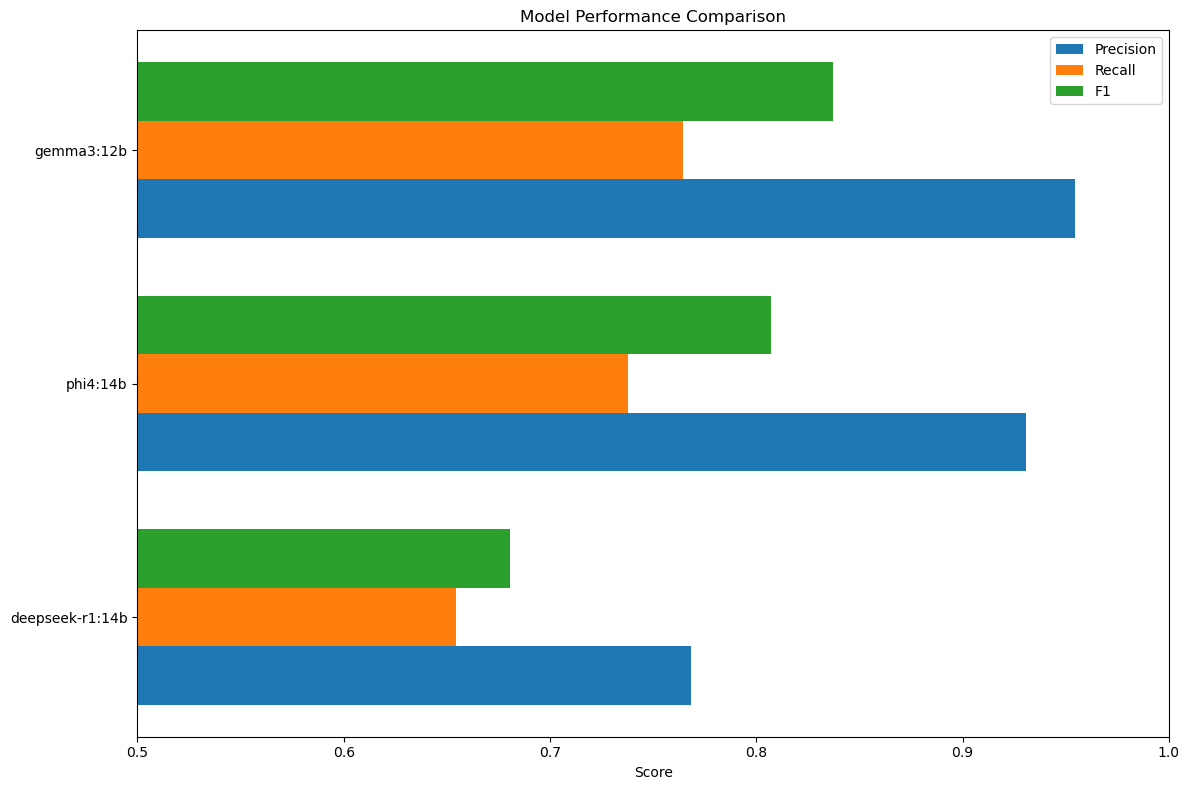

In [53]:
# Assuming your df is already loaded, reshape it
# Or if single column, reshape differently:
df_pivot = avg_results.reset_index()
df_pivot.columns = ['metric', 'model', 'value']
df_pivot = df_pivot.pivot(index='model', columns='metric', values='value')


# Filter out zero-performing models for cleaner visualization
df_plot = df_pivot[df_pivot['f1'] > 0].sort_values('f1', ascending=True)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(df_plot))
width = 0.25

ax.barh(x - width, df_plot['precision'], width, label='Precision')
ax.barh(x, df_plot['recall'], width, label='Recall')
ax.barh(x + width, df_plot['f1'], width, label='F1')

ax.set_yticks(x)
ax.set_yticklabels(df_plot.index)
ax.set_xlabel('Score')
ax.set_xlim(0.5, 1)
ax.legend()
ax.set_title('Model Performance Comparison')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

In [54]:

def create_f1_heatmap(results_df, output_path='f1_heatmap.png'):
    """
    Create a heatmap of F1 scores: models vs prompt strategies.
    """
    # Calculate mean F1 score for each model-prompt combination
    pivot_data = results_df.groupby(['model', 'prompt_strategy'])['f1'].mean().unstack()
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_data, 
        annot=True,  # Show F1 scores in cells
        fmt='.3f',   # 3 decimal places
        cmap='RdYlGn',  # Red-Yellow-Green colormap
        vmin=0, 
        vmax=1,
        cbar_kws={'label': 'F1 Score'}
    )
    
    plt.title('F1 Score Comparison: Models vs Prompt Strategies', fontsize=14, pad=20)
    plt.xlabel('Prompt Strategy', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Heatmap saved to {output_path}")
    return pivot_data


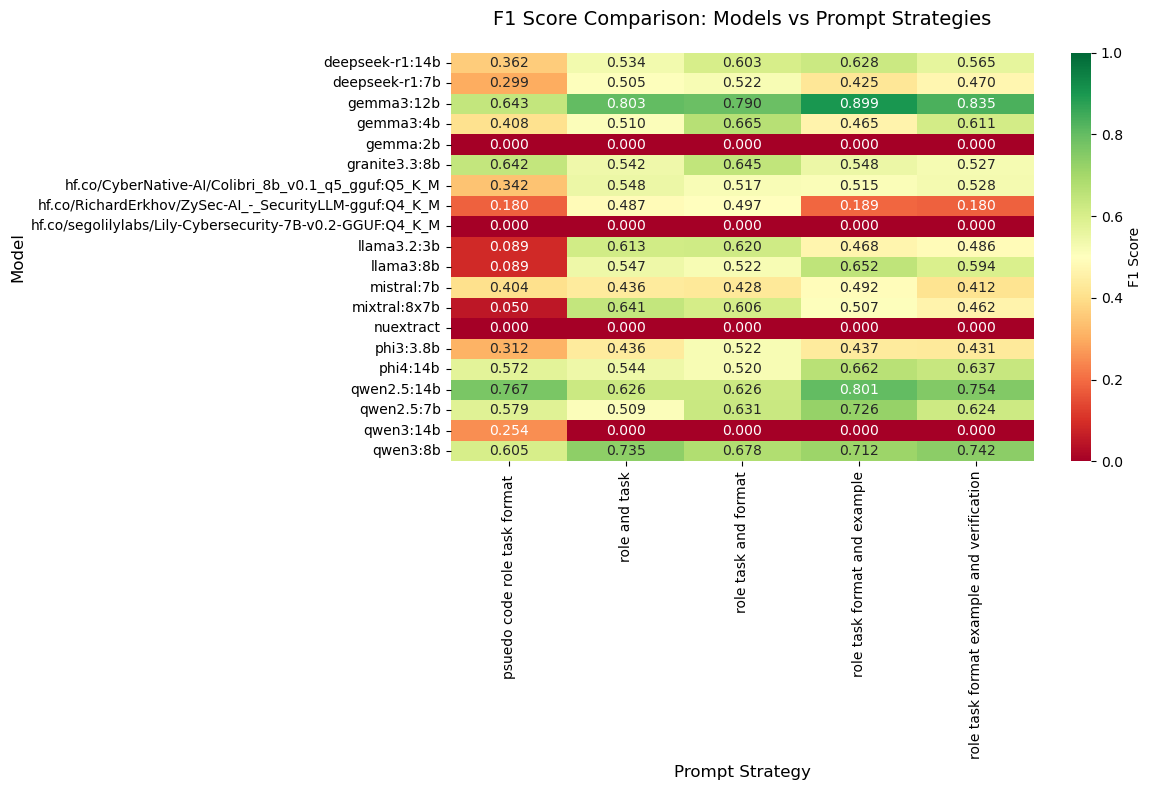


✓ Heatmap saved to f1_heatmap.png

Mean F1 Scores by Model and Prompt:
prompt_strategy                                     psuedo code role task format   \
model                                                                               
deepseek-r1:14b                                                          0.362424   
deepseek-r1:7b                                                           0.298571   
gemma3:12b                                                               0.643232   
gemma3:4b                                                                0.407570   
gemma:2b                                                                 0.000000   
granite3.3:8b                                                            0.641740   
hf.co/CyberNative-AI/Colibri_8b_v0.1_q5_gguf:Q5...                       0.342222   
hf.co/RichardErkhov/ZySec-AI_-_SecurityLLM-gguf...                       0.180000   
hf.co/segolilylabs/Lily-Cybersecurity-7B-v0.2-G...                       0.000

In [55]:
pivot_table = create_f1_heatmap(llm_results)
print("\nMean F1 Scores by Model and Prompt:")
print(pivot_table)

In [19]:
pivot_data = llm_chunk_results.groupby(['model', 'delimiter'])['f1'].mean().unstack()
document_df = llm_results[llm_results['prompt_strategy'] == 'role task format and example'].groupby(['model'])['f1'].mean()
pivot_data['document'] = document_df.loc[pivot_data.index]
pivot_data = pivot_data.rename(columns={'\n': 'paragraph', '. ': 'sentence', '\n\n': 'section'})

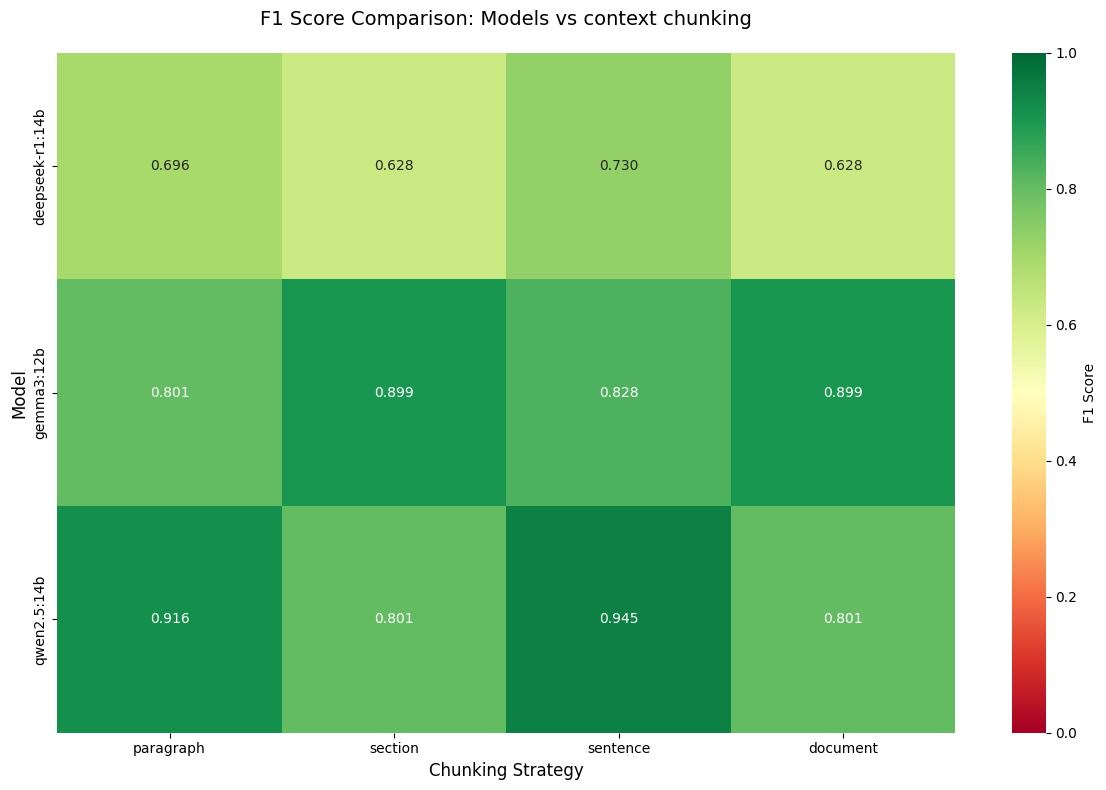

delimiter,paragraph,section,sentence,document
model,,,,
deepseek-r1:14b,0.695873,0.627843,0.730303,0.627843
gemma3:12b,0.801429,0.899446,0.828485,0.899446
qwen2.5:14b,0.915873,0.801025,0.945455,0.801025


In [20]:

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data, 
    annot=True,  # Show F1 scores in cells
    fmt='.3f',   # 3 decimal places
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    vmin=0, 
    vmax=1,
    cbar_kws={'label': 'F1 Score'}
)
    
plt.title('F1 Score Comparison: Models vs context chunking', fontsize=14, pad=20)
plt.xlabel('Chunking Strategy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
    

pivot_data

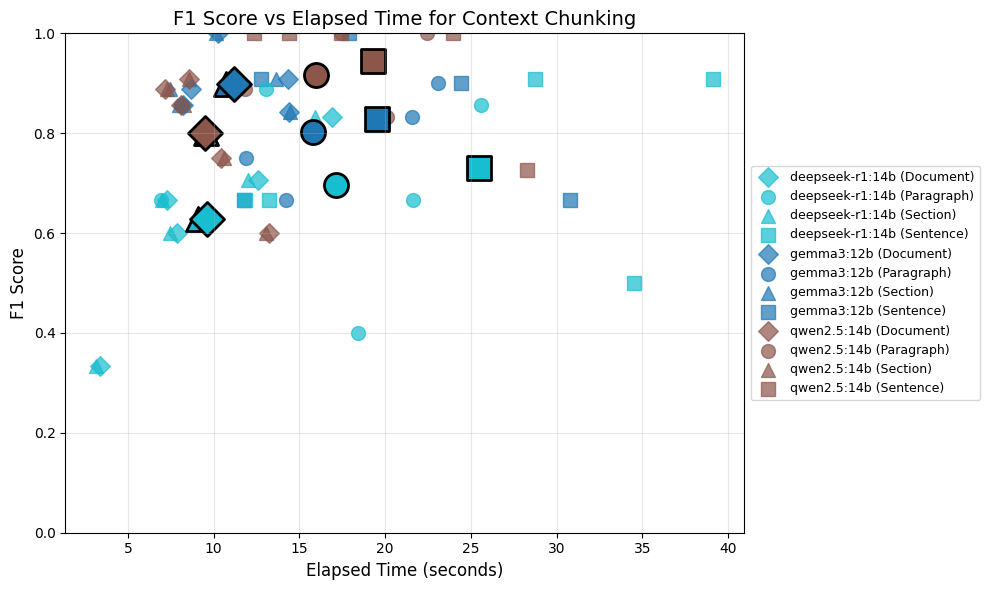

✓ Saved: chunking_f1_vs_time.png


In [25]:
# Plot F1 score vs Elapsed Time for chunking experiments
fig, ax = plt.subplots(figsize=(10, 6))

# Create color map for models
models_in_chunk = llm_chunk_results['model'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(models_in_chunk)))
color_map = dict(zip(models_in_chunk, colors))

# Create marker map for all 4 delimiter types
marker_map = {'\n': 'o', '. ': 's', '\n\n': '^', 'document': 'D'}
delimiter_labels = {'\n': 'Paragraph', '. ': 'Sentence', '\n\n': 'Section', 'document': 'Document'}

# Plot each model-delimiter combination from chunk results
for model in models_in_chunk:
    for delimiter in llm_chunk_results['delimiter'].unique():
        subset = llm_chunk_results[(llm_chunk_results['model'] == model) & 
                                    (llm_chunk_results['delimiter'] == delimiter)]
        if len(subset) > 0:
            ax.scatter(subset['elapsed_time'], subset['f1'], 
                      c=[color_map[model]], 
                      marker=marker_map.get(delimiter, 'o'),
                      s=100, alpha=0.7,
                      label=f"{model} ({delimiter_labels.get(delimiter, delimiter)})")

# Add document-level results from llm_results
document_results = llm_results[llm_results['prompt_strategy'] == 'role task format and example']
for model in models_in_chunk:
    subset = document_results[document_results['model'] == model]
    if len(subset) > 0:
        ax.scatter(subset['elapsed_time'], subset['f1'], 
                  c=[color_map[model]], 
                  marker=marker_map['document'],
                  s=100, alpha=0.7,
                  label=f"{model} ({delimiter_labels['document']})")

# Add average points for each model-delimiter combination (chunk results)
for model in models_in_chunk:
    for delimiter in llm_chunk_results['delimiter'].unique():
        subset = llm_chunk_results[(llm_chunk_results['model'] == model) & 
                                    (llm_chunk_results['delimiter'] == delimiter)]
        if len(subset) > 0:
            avg_time = subset['elapsed_time'].mean()
            avg_f1 = subset['f1'].mean()
            ax.scatter(avg_time, avg_f1, 
                      c=[color_map[model]], 
                      marker=marker_map.get(delimiter, 'o'),
                      s=300, alpha=1.0, edgecolors='black', linewidths=2)

# Add average points for document-level results
for model in models_in_chunk:
    subset = document_results[document_results['model'] == model]
    if len(subset) > 0:
        avg_time = subset['elapsed_time'].mean()
        avg_f1 = subset['f1'].mean()
        ax.scatter(avg_time, avg_f1, 
                  c=[color_map[model]], 
                  marker=marker_map['document'],
                  s=300, alpha=1.0, edgecolors='black', linewidths=2)

ax.set_xlabel('Elapsed Time (seconds)', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Elapsed Time for Context Chunking', fontsize=14)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Create legend with unique entries, sorted by model name
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# Sort labels by model name (extract model name before the parenthesis)
sorted_labels = sorted(by_label.keys(), key=lambda x: (x.split(' (')[0], x.split(' (')[1] if ' (' in x else ''))
sorted_handles = [by_label[label] for label in sorted_labels]
ax.legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

plt.tight_layout()
plt.savefig('chunking_f1_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: chunking_f1_vs_time.png")

In [22]:

successful = llm_results[llm_results['success'] == True]

print(f"=== LLM Experiment Summary ===")
print(f"Success rate: {len(successful)/len(llm_results)*100:.1f}% ({len(successful)}/{len(llm_results)})")

# Aggregate by model
model_avg = successful.groupby('model').agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'elapsed_time': 'mean'
}).round(3)
best_model = model_avg['f1'].idxmax()

dataset['llm_metrics'] = list(model_avg[model_avg.index == best_model].to_dict('index').values())[0]


print("\n=== Average Performance by Model ===")
print(model_avg.sort_values('f1', ascending=False))

# Aggregate by prompt strategy
prompt_avg = successful.groupby('prompt_strategy').agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'elapsed_time': 'mean'
}).round(3)

print("\n=== Average Performance by Prompt Strategy ===")
print(prompt_avg.sort_values('f1', ascending=False))

# Best overall result
best_result = successful.loc[successful['f1'].idxmax()]
print("\n=== Best Result ===")
print(f"Model: {best_result['model']}")
print(f"Prompt: {best_result['prompt_strategy']}")
print(f"F1: {best_result['f1']:.3f}")
print(f"Precision: {best_result['precision']:.3f}")
print(f"Recall: {best_result['recall']:.3f}")
print(f"Time: {best_result['elapsed_time']:.2f}s")

=== LLM Experiment Summary ===
Success rate: 100.0% (500/500)

=== Average Performance by Model ===
                                                    precision  recall     f1  \
model                                                                          
gemma3:12b                                              0.926   0.714  0.794   
qwen2.5:14b                                             0.935   0.590  0.715   
qwen3:8b                                                0.764   0.675  0.694   
qwen2.5:7b                                              0.836   0.515  0.614   
phi4:14b                                                0.880   0.460  0.587   
granite3.3:8b                                           0.846   0.472  0.581   
deepseek-r1:14b                                         0.745   0.445  0.538   
gemma3:4b                                               0.697   0.445  0.532   
hf.co/CyberNative-AI/Colibri_8b_v0.1_q5_gguf:Q5...      0.701   0.397  0.490   
llama3:8b           

In [49]:
# Figure 3: LLM Model Performance (if LLM experiments were run)
if 'successful' in locals() and len(successful) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    model_avg_sorted = model_avg.sort_values('f1', ascending=True)
    
    y_pos = np.arange(len(model_avg_sorted))
    ax.barh(y_pos, model_avg_sorted['f1'], color='steelblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_avg_sorted.index)
    ax.set_xlabel('F1-Score')
    ax.set_title('LLM Model base Performance Comparison')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(model_avg_sorted['f1']):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.savefig('llm_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: llm_model_comparison.png")

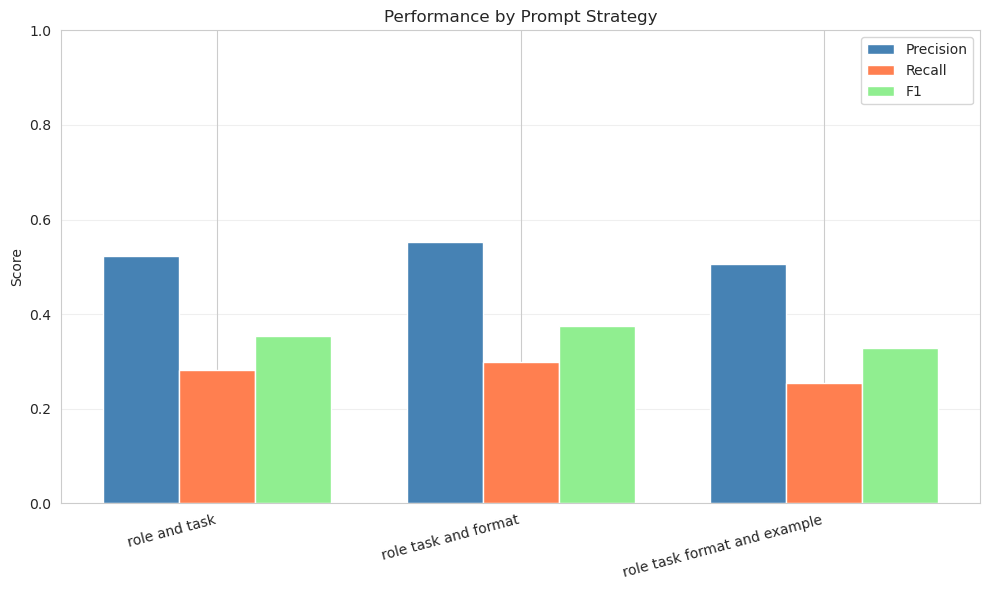

✓ Saved: prompt_strategy_comparison.png


In [51]:
# Figure 4: Prompt Strategy Performance (if LLM experiments were run)
if 'successful' in locals() and len(successful) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    prompt_names = prompt_avg.index
    x = np.arange(len(prompt_names))
    width = 0.25
    
    ax.bar(x - width, prompt_avg['precision'], width, label='Precision', color='steelblue')
    ax.bar(x, prompt_avg['recall'], width, label='Recall', color='coral')
    ax.bar(x + width, prompt_avg['f1'], width, label='F1', color='lightgreen')
    
    ax.set_ylabel('Score')
    ax.set_title('Performance by Prompt Strategy')
    ax.set_xticks(x)
    ax.set_xticklabels(prompt_names, rotation=15, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('prompt_strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: prompt_strategy_comparison.png")